In [1]:
import os
import wave
import shutil
import librosa
import pathlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook
import seaborn as sns
import pickle

%matplotlib inline
matplotlib.style.use('ggplot')

### config

In [2]:
fe_dir_name = 'logmel+delta_nmels128_duration2_nfft2560'

In [3]:
inter_dir = pathlib.Path('../data/interim/')
fe_dir = inter_dir / fe_dir_name
fe_dir

PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560')

### Loading data

In [4]:
data_dir = '../data/input/'
train_curated = pd.read_csv(data_dir + 'train_curated.csv')
train_noisy = pd.read_csv(data_dir + 'train_noisy.csv')
test = pd.read_csv(data_dir + 'sample_submission.csv')

In [6]:
train_curated["nframe"] = train_curated["fname"].apply(
    lambda f: wave.open(data_dir + "train_curated/" + f).getnframes()
)
train_noisy["nframe"] = train_noisy["fname"].apply(
    lambda f: wave.open(data_dir + "train_noisy/" + f).getnframes()
)
test["nframe"] = test["fname"].apply(
    lambda f: wave.open(data_dir + "test/" + f).getnframes()
)

In [7]:
train = pd.concat([train_curated, train_noisy], axis=0, sort=False, ignore_index=True)
train['noisy_flg'] = 0
train.loc[len(train_curated):len(train_curated) + len(train_noisy), 'noisy_flg'] = 1
train['n_labels'] = train['labels'].apply(lambda x: len(x.split(',')))

total = pd.concat([train, test[['fname', 'nframe']]], axis=0, sort=False, ignore_index=True)
total['test_flg'] = 0
total.loc[len(train):len(train) + len(test), 'test_flg'] = 1
total.head()

,fname,labels,nframe,noisy_flg,n_labels,test_flg
0,0006ae4e.wav,Bark,310456,0.0,1.0,0
1,0019ef41.wav,Raindrop,90616,0.0,1.0,0
2,001ec0ad.wav,Finger_snapping,66976,0.0,1.0,0
3,0026c7cb.wav,Run,1125886,0.0,1.0,0
4,0026f116.wav,Finger_snapping,60638,0.0,1.0,0


In [8]:
def load_data(filename):
    return pickle.load(open(filename, "rb"), encoding='latin1')

fe_list = list(pathlib.Path(fe_dir).glob("*.pkl"))
len(fe_list), fe_list[:3]

(25905,
 [PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/fe5bad8c.pkl'),
  PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/8ab02554.pkl'),
  PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/1d58040b.pkl')])

In [9]:
total

,fname,labels,nframe,noisy_flg,n_labels,test_flg
0,0006ae4e.wav,Bark,310456,0.0,1.0,0
1,0019ef41.wav,Raindrop,90616,0.0,1.0,0
2,001ec0ad.wav,Finger_snapping,66976,0.0,1.0,0
3,0026c7cb.wav,Run,1125886,0.0,1.0,0
4,0026f116.wav,Finger_snapping,60638,0.0,1.0,0
5,003be5db.wav,Whispering,623616,0.0,1.0,0
6,0041de6b.wav,"Acoustic_guitar,Strum",354778,0.0,2.0,0
7,004ca909.wav,Hi-hat,36750,0.0,1.0,0
8,00713ec2.wav,Bass_drum,18378,0.0,1.0,0
9,0073825a.wav,"Crowd,Cheering",224910,0.0,2.0,0


In [10]:
total.query("labels == 'Whispering'")

,fname,labels,nframe,noisy_flg,n_labels,test_flg
5,003be5db.wav,Whispering,623616,0.0,1.0,0
42,02a25949.wav,Whispering,65239,0.0,1.0,0
178,09ab7274.wav,Whispering,623616,0.0,1.0,0
267,0e7ed5d5.wav,Whispering,27890,0.0,1.0,0
280,0f12931e.wav,Whispering,176401,0.0,1.0,0
333,11a3989f.wav,Whispering,24320,0.0,1.0,0
365,13bff01c.wav,Whispering,128772,0.0,1.0,0
376,1447e255.wav,Whispering,447785,0.0,1.0,0
441,17c999bb.wav,Whispering,14740,0.0,1.0,0
534,1d44b0bd.wav,Whispering,623616,0.0,1.0,0


### check features

In [55]:
fname = '0006ae4e.wav'

In [56]:
fname_record = total.query('fname == @fname')
noisy_flg = fname_record["noisy_flg"].values[0]
test_flg = fname_record["test_flg"].values[0]

if test_flg == 1:
    wav_dir = data_dir + 'test/'
else:
    if noisy_flg == 0:
        wav_dir = data_dir + 'train_curated/'
    else:
        wav_dir = data_dir + 'train_noisy/'

print(wav_dir)
display(fname_record)
ipd.Audio(wav_dir + fname)

../data/input/train_curated/


,fname,labels,nframe,noisy_flg,n_labels,test_flg
0,0006ae4e.wav,Bark,310456,0.0,1.0,0


(3, 128, 448)


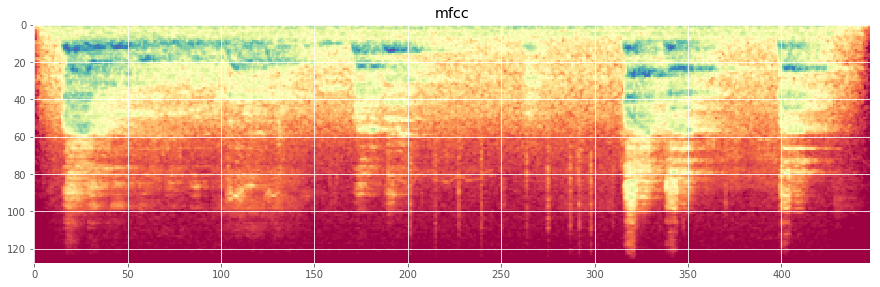

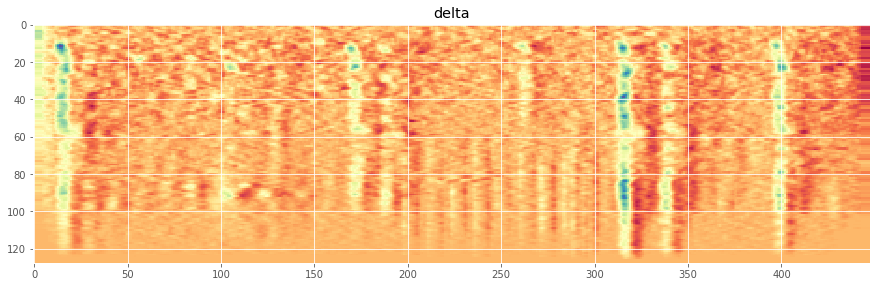

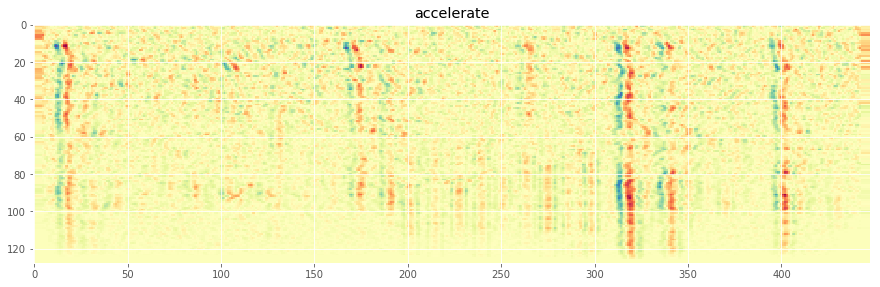

In [57]:
p_name = os.path.splitext(fname)[0] + '.pkl'
fe = load_data(fe_dir / p_name)
print(fe.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

### check augmentation（specAugment）

In [58]:
def standarize(X, eps=1e-6):
    """ X is 2d-array. X.shape = (xx, yy)
    """
    max_ = X.max()
    min_ = X.min()
    if (max_ - min_) > eps:
        # normalize to [0, 255]
        # X = (X - min_) / (max_ - min_) * 255
        # normalize to [0, 1]
        X = (X - min_) / (max_ - min_)
    else:
        # just zero
        X = np.zeros_like(X)

    # X = X.astype(np.uint8)
    return X

fe_sc = fe.copy()
for i in range(3):
    fe_sc[i, :, :] = standarize(fe[i, :, :])

In [59]:
import random
import torch

def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]     
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = torch.tensor([[[y, point_to_warp]]]), torch.tensor([[[y, point_to_warp + dist_to_warp]]])
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

time_warp(fe)

AssertionError: 

(3, 128, 448)


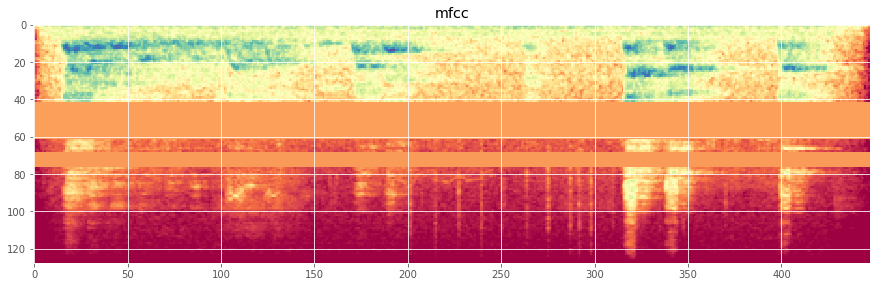

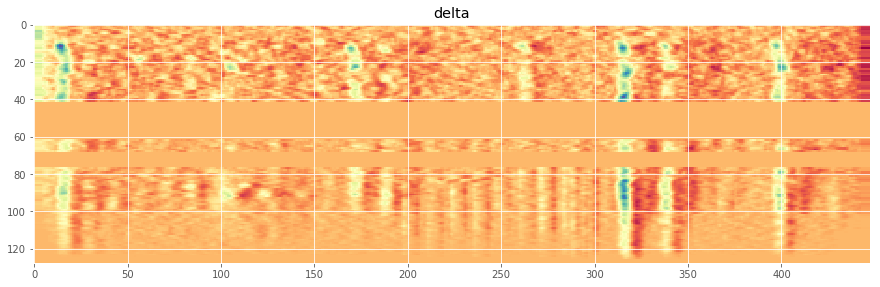

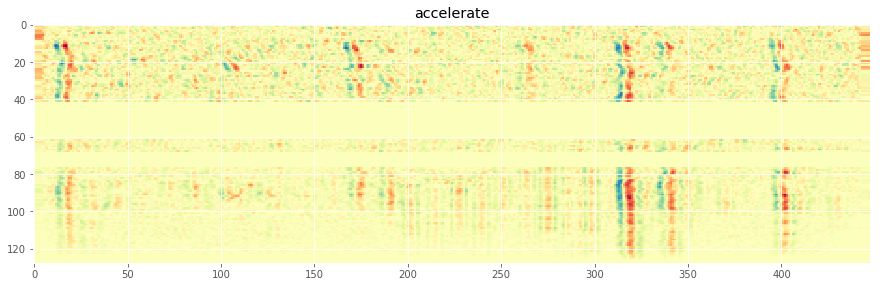

In [77]:
def freq_mask(data, F=30, num_masks=1, replace_with_zero=False):
    spec = data.copy()   # data.shape = (3, n_mel, xx)
    num_mel_channels = spec.shape[1]

    for i in range(num_masks):
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)
        
        if f_zero == f_zero + f:
            # avoids randrange error if values are equal and range is empty
            return spec

        mask_end = random.randrange(f_zero, f_zero + f)
        if replace_with_zero:
            spec[:, f_zero:mask_end, :] = 0
        else:
            for i_channel in range(spec.shape[0]):
                spec[i_channel, f_zero:mask_end, :] = spec[i_channel].mean()
    
    return spec


fe_freq_mask = freq_mask(fe_sc, F=30, num_masks=2, replace_with_zero=False)
print(fe_freq_mask.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

In [ ]:
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):        
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned